In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import os

FILE_SUFFIX = "1"

print("Step 1: Loading the dataset.")
df = pd.read_csv('datasets/drug_overdose.csv')

print("Step 2: Cleaning the data and engineering features.")

df = df[df['Indicator'] == 'Number of Drug Overdose Deaths'].copy()

df.dropna(subset=['Data Value'], inplace=True)

cols_to_drop = ['State', 'Period', 'Footnote', 'Footnote Symbol',
                'Predicted Value', 'Percent Complete', 'Percent Pending Investigation']
df.drop(columns=cols_to_drop, inplace=True)

print("Step 3: Separating features (X) and target (y).")
y = df['Data Value']
X = df[['State Name', 'Year']]

print("Step 4: Identifying and preprocessing numerical and categorical columns.")
categorical_cols = ['State Name']
numeric_cols = ['Year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X).toarray()

y_scaler = StandardScaler()
y_processed = y_scaler.fit_transform(y.values.reshape(-1, 1))

os.makedirs("artifacts", exist_ok=True)

joblib.dump(preprocessor.named_transformers_['num'], f"artifacts/feature_scaler{FILE_SUFFIX}.joblib")
print(f"Saved numeric feature scaler to artifacts/feature_scaler{FILE_SUFFIX}.joblib")

joblib.dump(preprocessor.named_transformers_['cat'], f"artifacts/onehot_encoder{FILE_SUFFIX}.joblib")
print(f"Saved one-hot encoder to artifacts/onehot_encoder{FILE_SUFFIX}.joblib")

joblib.dump(y_scaler, f"artifacts/target_scaler{FILE_SUFFIX}.joblib")
print(f"Saved target scaler to artifacts/target_scaler{FILE_SUFFIX}.joblib")

print("\nStep 5: Combining and saving the cleaned data to a CSV file.")
feature_names = preprocessor.get_feature_names_out()

cleaned_df = pd.DataFrame(X_processed, columns=feature_names)
cleaned_df['scaled_data_value'] = y_processed

cleaned_df.to_csv(f'cleaned_overdose_data{FILE_SUFFIX}.csv', index=False)
print(f"File 'cleaned_overdose_data{FILE_SUFFIX}.csv' has been saved successfully.")

print("\nData preprocessing complete.")

Step 1: Loading the dataset.
Step 2: Cleaning the data and engineering features.
Step 3: Separating features (X) and target (y).
Step 4: Identifying and preprocessing numerical and categorical columns.
Saved numeric feature scaler to artifacts/feature_scaler1.joblib
Saved one-hot encoder to artifacts/onehot_encoder1.joblib
Saved target scaler to artifacts/target_scaler1.joblib

Step 5: Combining and saving the cleaned data to a CSV file.
File 'cleaned_overdose_data1.csv' has been saved successfully.

Data preprocessing complete.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import shap

print("\nStep 1: Loading the cleaned dataset.")
df = pd.read_csv(f'cleaned_overdose_data{FILE_SUFFIX}.csv')

print("Step 2: Separating features (X) and target (y).")

X = df.drop(columns='scaled_data_value').values.astype(np.float32)
y = df['scaled_data_value'].values.astype(np.float32).reshape(-1, 1)

feature_names = df.drop(columns='scaled_data_value').columns.tolist()

print("Step 3: Splitting the data into training and testing sets.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

print("Step 4: Building the feedforward neural network model.")

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Step 5: Training the model.")

baseline_model = RegressionNN(X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    baseline_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = baseline_model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Training MSE: {avg_loss:.4f}")

MODEL_SAVE_PATH = f"regression_baseline_model{FILE_SUFFIX}.pth" 
torch.save(baseline_model.state_dict(), MODEL_SAVE_PATH)
print(f"\nBaseline model saved to {MODEL_SAVE_PATH}")

print("\nStep 6: Evaluating the model on the test data.")

baseline_model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = baseline_model(xb).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\n" + "="*40)
print("MODEL EVALUATION METRICS (Baseline)")
print("="*40)

all_true_np = np.array(all_true)
all_preds_np = np.array(all_preds)


test_mse = mean_squared_error(all_true_np, all_preds_np)
test_mae = mean_absolute_error(all_true_np, all_preds_np)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(all_true_np, all_preds_np)

print(f"Mean Squared Error (MSE):      {test_mse:.4f}")
print(f"**Mean Absolute Error (MAE):** {test_mae:.4f}")
print(f"**Root Mean Squared Error (RMSE):** {test_rmse:.4f}")
print(f"**R-squared (R²):** {test_r2:.4f}")

print("\n--- Privacy Metrics ---")
print("**Epsilon:** Not Applicable (N/A) - This is a non-private baseline model.")
print("**Delta:** Not Applicable (N/A) - This is a non-private baseline model.")
print("="*40 + "\n")

print("\nStep 7: Generating SHAP explanations using DeepExplainer.")

background_size = min(100, len(X_train))
background_data = torch.tensor(
    X_train[np.random.choice(X_train.shape[0], background_size, replace=False)],
    dtype=torch.float32
).to(device)

X_explain = torch.tensor(X_test[:20], dtype=torch.float32).to(device)

explainer = shap.DeepExplainer(baseline_model, background_data)
shap_values = explainer.shap_values(X_explain)

if isinstance(shap_values, list):
    shap_values = shap_values[0]

if shap_values.ndim > 2:
    shap_values = np.squeeze(shap_values)

mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
feature_importance = dict(zip(feature_names, mean_abs_shap))

print("\n**Average absolute SHAP values (feature importance):**")
for f, val in feature_importance.items():
    print(f"{f}: {float(val):.4f}")

print("\nStep 8: Saving SHAP feature importance to CSV.")

shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

shap_df.to_csv(f'shap_feature_importance{FILE_SUFFIX}.csv', index=False) 
print(f"Saved SHAP feature importance to 'shap_feature_importance{FILE_SUFFIX}.csv'.") # <-- MODIFIED

print("\nModel training, evaluation, and SHAP explainability are complete.")
os.makedirs("artifacts", exist_ok=True)
torch.save(baseline_model.state_dict(), f"artifacts/regression_model{FILE_SUFFIX}.pt")


Step 1: Loading the cleaned dataset.
Step 2: Separating features (X) and target (y).
Step 3: Splitting the data into training and testing sets.
Step 4: Building the feedforward neural network model.
Step 5: Training the model.
Epoch [10/100] - Training MSE: 0.0154
Epoch [20/100] - Training MSE: 0.0115
Epoch [30/100] - Training MSE: 0.0095
Epoch [40/100] - Training MSE: 0.0081
Epoch [50/100] - Training MSE: 0.0048
Epoch [60/100] - Training MSE: 0.0042
Epoch [70/100] - Training MSE: 0.0043
Epoch [80/100] - Training MSE: 0.0047
Epoch [90/100] - Training MSE: 0.0034
Epoch [100/100] - Training MSE: 0.0054

Baseline model saved to regression_baseline_model1.pth

Step 6: Evaluating the model on the test data.

MODEL EVALUATION METRICS (Baseline)
Mean Squared Error (MSE):      0.0026
**Mean Absolute Error (MAE):** 0.0148
**Root Mean Squared Error (RMSE):** 0.0506
**R-squared (R²):** 0.9977

--- Privacy Metrics ---
**Epsilon:** Not Applicable (N/A) - This is a non-private baseline model.
**Del

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os

print("Step 1: Loading cleaned data...")
data_path = f"cleaned_overdose_data{FILE_SUFFIX}.csv"
df = pd.read_csv(data_path)

print("Step 2: Splitting features and target...")
X = df.drop(columns=['scaled_data_value']).values.astype(np.float32)
y = df['scaled_data_value'].values.astype(np.float32)

print("Step 3: Creating train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

input_dim = X_train.shape[1]

print("Step 4: Loading trained model...")

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = RegressionNN(input_dim).to(device)

weights_path = f"artifacts/regression_model{FILE_SUFFIX}.pt"
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Trained model weights not found at {weights_path}")

baseline_model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
baseline_model.eval()

def model_inversion_attack(model, target_value, input_dim, num_steps=1000, lr=0.01, lambda_reg=1e-4):
    """
    Attempt to reconstruct a plausible input vector that produces the given target_value.
    """
    baseline_model.eval()

    recon_input = torch.randn((1, input_dim), requires_grad=True, device=device)

    optimizer = optim.Adam([recon_input], lr=lr)
    loss_fn = nn.MSELoss()

    target_tensor = torch.tensor([[target_value]], dtype=torch.float32, device=device)

    for step in range(num_steps):
        optimizer.zero_grad()
        prediction = model(recon_input)
        
        loss = loss_fn(prediction, target_tensor)
        loss += lambda_reg * torch.norm(recon_input)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}/{num_steps} - Pred: {prediction.item():.4f} - Loss: {loss.item():.6f}")

    return recon_input.detach().cpu().numpy()

print("\nStep 5: Running Model Inversion Attack...")

known_targets = y_test[:5]

reconstructed_inputs = []
for tval in known_targets:
    print(f"\nReconstructing input for target value: {tval:.4f}")
    recon = model_inversion_attack(baseline_model, tval, input_dim)
    reconstructed_inputs.append(recon)

reconstructed_inputs = np.vstack(reconstructed_inputs)

print("\nReconstructed Feature Vectors (in scaled feature space):")
print(reconstructed_inputs)

os.makedirs("artifacts", exist_ok=True)

np.save(f"artifacts/reconstructed_inputs{FILE_SUFFIX}.npy", reconstructed_inputs) 
print(f"\nSaved reconstructed inputs to artifacts/reconstructed_inputs{FILE_SUFFIX}.npy")

Step 1: Loading cleaned data...
Step 2: Splitting features and target...
Step 3: Creating train-test split...
Step 4: Loading trained model...

Step 5: Running Model Inversion Attack...

Reconstructing input for target value: 8.2064
Step 0/1000 - Pred: 15.5374 - Loss: 53.743916
Step 100/1000 - Pred: 8.2032 - Loss: 0.000706
Step 200/1000 - Pred: 8.2066 - Loss: 0.000695
Step 300/1000 - Pred: 8.2064 - Loss: 0.000695
Step 400/1000 - Pred: 8.2064 - Loss: 0.000695
Step 500/1000 - Pred: 8.2064 - Loss: 0.000695
Step 600/1000 - Pred: 8.2064 - Loss: 0.000695
Step 700/1000 - Pred: 8.2064 - Loss: 0.000695
Step 800/1000 - Pred: 8.2064 - Loss: 0.000695
Step 900/1000 - Pred: 8.2064 - Loss: 0.000695

Reconstructing input for target value: -0.1112
Step 0/1000 - Pred: 10.7260 - Loss: 117.444290
Step 100/1000 - Pred: -0.3407 - Loss: 0.053461
Step 200/1000 - Pred: -0.3217 - Loss: 0.045074
Step 300/1000 - Pred: -0.2981 - Loss: 0.035689
Step 400/1000 - Pred: -0.2551 - Loss: 0.021468
Step 500/1000 - Pred: -0

Loading original cleaned dataset...
Loading saved scalers/encoders and reconstructed inputs...
Reversing scaling to get real feature values...
Reconstructed feature values saved to artifacts/reconstructed_real_values1.csv
Showing reconstructed sensitive features (State Name, Year)...


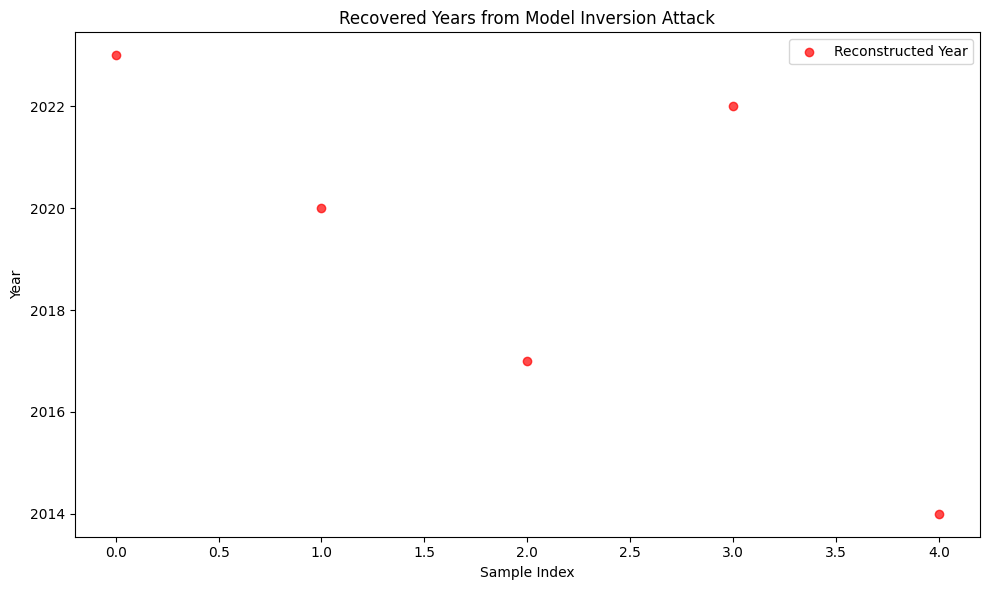


Sample of reverse-engineered sensitive data:
   Year     State Name
0  2023        Georgia
1  2020  New York City
2  2017     California
3  2022    Connecticut
4  2014       Delaware

 Done — reconstructed original 'State Name' and 'Year' from model outputs.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib

print("Loading original cleaned dataset...")
data_path = f"cleaned_overdose_data{FILE_SUFFIX}.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}")

df = pd.read_csv(data_path)

target_col = "scaled_data_value"
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found in dataset. Columns are: {df.columns.tolist()}")

X = df.drop(columns=[target_col])

print("Loading saved scalers/encoders and reconstructed inputs...")

feature_scaler_path = f"artifacts/feature_scaler{FILE_SUFFIX}.joblib"
onehot_encoder_path = f"artifacts/onehot_encoder{FILE_SUFFIX}.joblib"
recon_path = f"artifacts/reconstructed_inputs{FILE_SUFFIX}.npy"

for p in [feature_scaler_path, onehot_encoder_path, recon_path]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Required file not found at {p}")

feature_scaler = joblib.load(feature_scaler_path)
onehot_encoder = joblib.load(onehot_encoder_path)
recon_scaled = np.load(recon_path)

num_features = 1
cat_features = recon_scaled.shape[1] - num_features

recon_num = recon_scaled[:, :num_features]
recon_cat = recon_scaled[:, num_features:]

print("Reversing scaling to get real feature values...")

recon_years = feature_scaler.inverse_transform(recon_num).flatten()
recon_states = onehot_encoder.inverse_transform(recon_cat).flatten()

recon_df = pd.DataFrame({
    "Year": np.round(recon_years).astype(int),
    "State Name": recon_states
})

os.makedirs("artifacts", exist_ok=True)
save_path = f"artifacts/reconstructed_real_values{FILE_SUFFIX}.csv"
recon_df.to_csv(save_path, index=False)
print(f"Reconstructed feature values saved to {save_path}")

print("Showing reconstructed sensitive features (State Name, Year)...")

plt.figure(figsize=(10, 6))
plt.scatter(range(len(recon_df)), recon_df["Year"], c="red", label="Reconstructed Year", alpha=0.7)
plt.title("Recovered Years from Model Inversion Attack")
plt.xlabel("Sample Index")
plt.ylabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

print("\nSample of reverse-engineered sensitive data:")
print(recon_df.head(10))

print("\n Done — reconstructed original 'State Name' and 'Year' from model outputs.")